**ML COURSE 2024-2025**
# LAB9  EXPLAINABLE AI

In this notebook, we will see some techniques to explain machine learning model predictions.

In [1]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

random.seed(0)
np.random.seed(0)

## Dataset: loading and pre-processing

The dataset is a collection of records on a heart condition called AHD. Our task is to predict if a patient has it based solely on age, gender, chest pain, cholesterol, and other heart and lung function measurements for a total of 13 features.

In [2]:
# download the dataset
csv_dataset = pd.read_csv("https://www.statlearning.com/s/Heart.csv")
csv_dataset = csv_dataset.drop(csv_dataset.columns[0], axis=1)
display(csv_dataset)

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,typical,110,264,0,0,132,0,1.2,2,0.0,reversable,Yes
299,68,1,asymptomatic,144,193,1,0,141,0,3.4,2,2.0,reversable,Yes
300,57,1,asymptomatic,130,131,0,0,115,1,1.2,2,1.0,reversable,Yes
301,57,0,nontypical,130,236,0,2,174,0,0.0,2,1.0,normal,Yes


**One-hot encoding of categorical features**
**One hot encoding** converts a categorical feature into binary <u>vector</u>. Each category is represented by a vector with a 1 in the position of the category and 0s elsewhere. 

Example for ChestPain:
Categories = `[typical, asymptomatic, nonanginal, nontypical]`
- `typical` → `[1, 0, 0, 0]`  
- `asymptomatic` → `[0, 1, 0, 0]`  
- `nonanginal` → `[0, 0, 1, 0]`
- `nontypical` → `[0, 0, 0, 1]`

**One-hot vs Label Encoding**
Label encoding is another way to deal with categorical features and it assigns an integer to each category:  
- `typical` → `1`  
- `asymptomatic` → `2`  
- `nonanginal` → `3`
- `nontypical` → `4`

Where to use each: 
- label encoding: typically for **ordinal** features, where the order matters (e.g., young < adult < elder)
- one-hot encoding: typically for **nominal** features with no inherent order (e.g., color).
The choice also depends on the requirements of the model. 

> Note: one-hot encoding increases dataset dimensionality (the number of features).

In [3]:
# change each categorical feature to a one-hot encoding (ChestPain, Ca, Thal, AHD)
for col in ["ChestPain", "Ca", "Thal", "AHD"]:
    one_hot_encoded = pd.get_dummies(csv_dataset[col], col, drop_first=True)
    csv_dataset = pd.concat([csv_dataset, one_hot_encoded], axis=1)
    csv_dataset = csv_dataset.drop(col, axis=1)

# convert to numpy (we need to convert it to float64 as some columns are integers - technical detail not needed in the exam)
dataset = csv_dataset.to_numpy()
X = dataset[:, :-1]  # all columns except the last
y = dataset[:, -1]   # last column

X = X.astype(np.float64)  # convert to float64
y = y.astype(np.float64)  # convert to float64

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# normalize the dataset using training metrics
min_vals_train = np.min(X_train, axis=0)
max_vals_train = np.max(X_train, axis=0)
X_train = np.divide(X_train - min_vals_train, max_vals_train - min_vals_train)  
X_test = np.divide(X_test - min_vals_train, max_vals_train - min_vals_train)  # using the values computed on the training set! 

## Logistic Regression

As seen during lectures, logistic regression is for classification problems, and it shares almost the same structure to linear regression, with an additional transformation to map it to probabilities:
$$
y = \sigma(\beta_0 + \beta_1 x_1 + \beta_2 x_2 +...)\\
\sigma(x) = \frac{1}{1+e^{-x}}
$$
For this reason, the model weights $\beta_i$ are also a way to interpret the model.

Note:  
it's important that the features are on the same scale, otherwise the importance of the features might be missaligned if interpreted via the model weights.  
Indeed, consider the univariate case:
$$
\sigma(\beta_0 + \beta_1 x_1)\,\,\,\,=\,\,\,\, \sigma(\beta_0 + \frac{\beta_1}{100} (100\cdot x_1))
$$
Therefore, enlarging $x_1$ by a factor of 100, will give the same solution as the initial problem, with its corresponding coefficient 100 smaller (thus the effect of $x_1$ might be missinterpreted)

In [4]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [5]:
print(f"""
Train accuracy: {accuracy_score(y_train, clf.predict(X_train))}
Test accuracy: {accuracy_score(y_test, clf.predict(X_test))}
""")


Train accuracy: 0.8571428571428571
Test accuracy: 0.85



### Importance by parameters

Text(0, 0.5, 'importance')

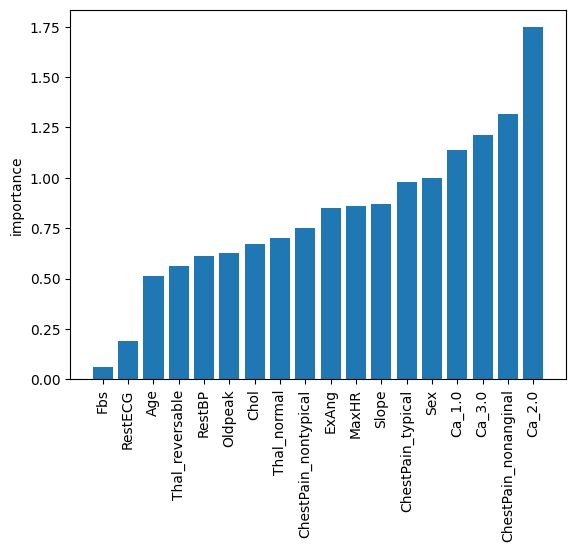

In [6]:
# we only care about the magnitude of the parameters 
weights_importances = np.abs(clf.coef_[0])
columns = csv_dataset.columns 

# sort the columns by importance 
idx = np.argsort(weights_importances)
plt.bar(columns.to_numpy()[idx], weights_importances[idx])
plt.xticks(columns.to_numpy()[idx], rotation = "vertical")
plt.ylabel("importance")

However, this is a single split of the data, and might not represent correctly how "effective" a model is for a specific problem (a different train/test split might lead to different results, especially in low data regimes)

For this reason, usually cross validation is used. Remember that it consist in splitting the dataset in N parts, use N-1 to train the model, and the remaining one to test it, and averages the results over all possible hold-outs.

In [7]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=20)
print(scores)

[0.9375     0.875      0.8125     0.8        0.8        0.93333333
 0.93333333 1.         0.86666667 0.86666667 0.8        0.73333333
 0.86666667 0.86666667 0.73333333 0.93333333 0.73333333 0.73333333
 0.8        0.8       ]


However, the model might have different "opinions" on what is important and what's not during the different trainings, and it's obvious how to aggregate the importances

### Importance by shrinkage

As seen during lecture, LASSO gives us a handy way to force the model to focus the attention on only few features, by adding a penalty on the weights.

In [8]:
from sklearn import linear_model
# let's define the set of values we want to test of lambda (the higher, the stronger the regularization)
lambdas = np.linspace(0.001,0.13,30)
weights = []
for l in lambdas:
  # train the model with the specified regularization
  clf = linear_model.Lasso(alpha=l).fit(X_train, y_train)
  # store its parameters
  weights.append(clf.coef_)

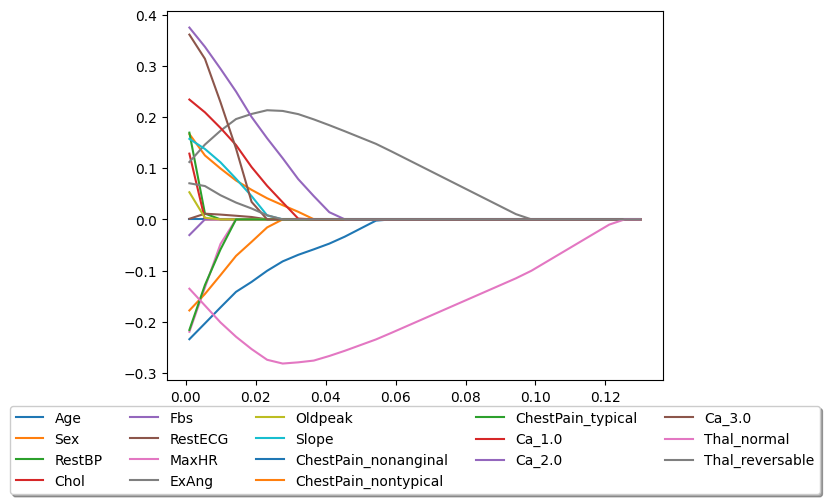

In [9]:
# plot the parameters of the models varying lambda
_ = plt.plot(lambdas, weights)
plt.legend(csv_dataset.columns, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

It can be seen how the order of importances changes while varying the penalty.

## Partial Dependence plot

Now, non linear models, such as decision trees, and even more random forest, are harder to interpret on the feature space. Indeed, "non linear" means that sometimes it might be that a feature influences the prediction directly proportionally, and some times inversely proportionally.

Above 2 features (since the 3rd dimension will be used for the prediction) it's impossible to plot this dependency, thus we can rely on what are knonw as "partial dependence plot".

In poor words, it means "let's fix N-1 features, and let's see how the prediction changes by varying the Nth feature".

However, the problem of this approach is the "let's fix N-1 features", since there is no "default value" to give to a feature, and the "fixed values" have to come from the joint distribution $p(x_0, x_1, ...)$ (outside of that, we have no guarantee on what the model will predict, as it's considered "extrapolation").

In order to ensure that, we can pick a sample from the dataset, and take N-1 features from it, and vary the last one. Now, the range over which to vary this last feature, usually can be done by finding the min value and the max value from the dataset of that feature (in our case, every feature has been normalized in 0-1, so the answer is straightforward).

**IMPORTANT**: the way you have to read all the PDPs is _"this would be how the prediction for THIS specific sample would vary, by chaning THIS/THESE features of it"_  
In orther words, you have to keep in mind that it's a plot for the specific considered sample, and for the specific considered features of it.

In [10]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, random_state=0).fit(X_train, y_train)

In [11]:
# we will use feature at index 3, which is "Chol"
n_samples = 100
# define the various values we want to test
values = np.linspace(0,1, n_samples)
sample = X_train[None, 0].copy().repeat(n_samples, axis=0)
sample[:,3] = values

# predict varying that specific feature on that specific sample
predictions = clf.predict_proba(sample)[:,0]

Text(0, 0.5, 'prediction $p(y = 0 | x)$')

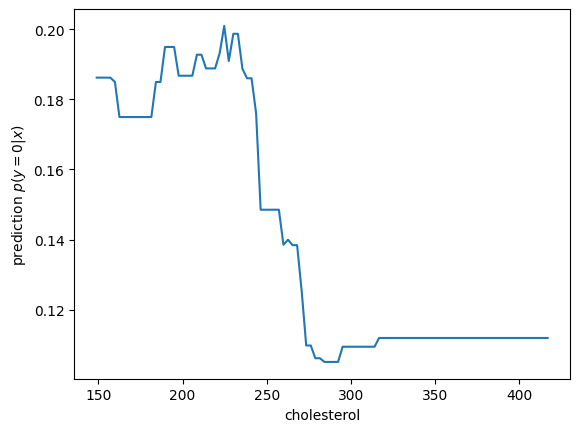

In [12]:
range_feature_3 = max_vals_train[3]- min_vals_train[3]
plt.plot(values * range_feature_3 + min_vals_train[3], predictions)
plt.xlabel("cholesterol")
plt.ylabel("prediction $p(y = 0 | x)$")

Indeeed, for a different sample, the plot might be very different

Text(0, 0.5, 'prediction $p(y = 0 | x)$')

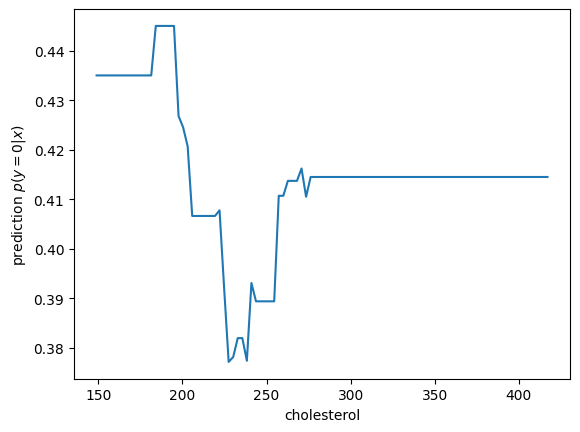

In [13]:
# we will use feature at index 3, which is "Chol"
n_samples = 100
# define the various values we want to test
values = np.linspace(0,1, n_samples)
sample = X_train[None, 1].copy().repeat(n_samples, axis=0)
sample[:,3] = values

# predict varying that specific feature on that specific sample
predictions = clf.predict_proba(sample)[:,0]

plt.plot(values * range_feature_3 + min_vals_train[3], predictions)
plt.xlabel("cholesterol")
plt.ylabel("prediction $p(y = 0 | x)$")

As said earlier, the plot might also be done for a pair of variables, and using the third dimension to observe the change (though in this case, the hypercube considered for the plot might get also out of the joint distribution, so it's not really ideal)

In [14]:
n_samples = 100
# we will consider Chol and Age, as both are continuous variables
values = np.linspace(0,1, n_samples)
# define the range of values we want to test
values1 = values[None, :].repeat(n_samples, axis=0).reshape((-1,))
values2 = values[:, None].repeat(n_samples, axis=1).reshape((-1,))
sample = X_train[None, 0].copy().repeat(n_samples**2, axis=0)
sample[:,3] = values1
sample[:,0] = values2
# predict varying the 2 features of that specific sample
predictions = clf.predict_proba(sample)[:,0]

In [15]:
import plotly.graph_objects as go
range_feature_0 = max_vals_train[0] - min_vals_train[0]
fig = go.Figure(data=[go.Surface(
    x=values * range_feature_3 + min_vals_train[3],
    y=values * range_feature_0 + min_vals_train[0],
    z=predictions.reshape((n_samples, n_samples)),
    )])
fig.update_scenes(xaxis_title_text='Chol',
                  yaxis_title_text='Age',
                  zaxis_title_text='Prediction')

fig.update_layout(title='Prediction varying Age and Chol', autosize=False,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

## Evaluation of Feature Importance Performance via Feature Selection

- A plot can be made of the performance after removing the most important feature, then the top two, and so on.  
- Another plot can be made of the performance by keeping only the most important feature, then the top two, and so on.

The area between these two curves represents a metric of how well feature importance works, evaluated through the proxy task of feature selection.

Any algorithm can be evaluated; in this example, we use Random Forest with **scikit-learn** to compute feature importance.

100%|██████████| 3/3 [01:16<00:00, 25.41s/it]


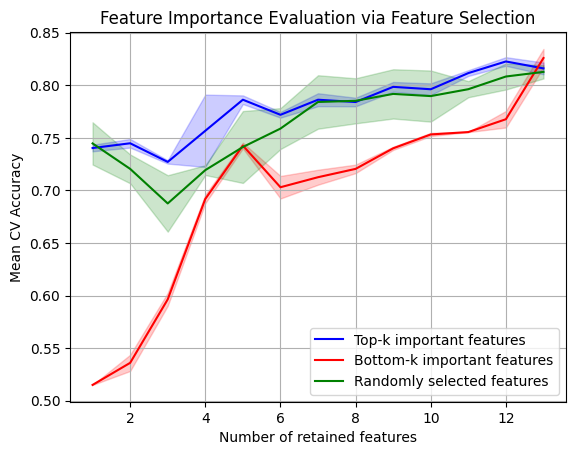

In [16]:
from tqdm import trange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
np.random.seed(1)

# Load dataset
csv_dataset = pd.read_csv("https://www.statlearning.com/s/Heart.csv")
csv_dataset = csv_dataset.drop(csv_dataset.columns[0], axis=1)

# Encode categorical variables
for col in csv_dataset.select_dtypes(include='object').columns:
    csv_dataset[col] = LabelEncoder().fit_transform(csv_dataset[col].astype(str))

X = csv_dataset.drop('AHD', axis=1)
y = csv_dataset['AHD']
n_features = X.shape[1]

scores_topk_global = []
scores_bottomk_global = []
scores_random_global = []

for i in trange(3):
    # Fit Random Forest and compute importances
    model = RandomForestClassifier(random_state=i)
    model.fit(X, y)
    importances = model.feature_importances_
    indices_desc = np.argsort(importances)[::-1]  # Most to least important
    indices_asc = np.argsort(importances)         # Least to most important
    indices_random = np.random.permutation(n_features)  # Random order
    features = X.columns

    scores_topk = []
    scores_bottomk = []
    scores_random = []

    # Evaluate performance using top-k and bottom-k features
    for k in range(1, n_features + 1):
        top_k_features = features[indices_desc[:k]]
        bottom_k_features = features[indices_asc[:k]]

        score_topk = cross_val_score(model, X[top_k_features], y, cv=5).mean()
        score_bottomk = cross_val_score(model, X[bottom_k_features], y, cv=5).mean()
        scores_randomk = cross_val_score(model, X[features[indices_random[:k]]], y, cv=5).mean()
        
        scores_topk.append(score_topk)
        scores_bottomk.append(score_bottomk)
        scores_random.append(scores_randomk)
    scores_topk_global.append(scores_topk)
    scores_bottomk_global.append(scores_bottomk)
    scores_random_global.append(scores_random)
        

# Convert global scores to numpy arrays for easier manipulation
scores_topk_global = np.array(scores_topk_global)
scores_bottomk_global = np.array(scores_bottomk_global)
scores_random_global = np.array(scores_random_global)

# Compute mean and standard deviation for each k
mean_topk = scores_topk_global.mean(axis=0)
std_topk = scores_topk_global.std(axis=0)

mean_bottomk = scores_bottomk_global.mean(axis=0)
std_bottomk = scores_bottomk_global.std(axis=0)

mean_random = scores_random_global.mean(axis=0)
std_random = scores_random_global.std(axis=0)

# Plot with shaded areas for standard deviation
plt.plot(range(1, n_features + 1), mean_topk, label="Top-k important features", color='blue')
plt.fill_between(range(1, n_features + 1), mean_topk - std_topk, mean_topk + std_topk, color='blue', alpha=0.2)

plt.plot(range(1, n_features + 1), mean_bottomk, label="Bottom-k important features", color='red')
plt.fill_between(range(1, n_features + 1), mean_bottomk - std_bottomk, mean_bottomk + std_bottomk, color='red', alpha=0.2)

plt.plot(range(1, n_features + 1), mean_random, label="Randomly selected features", color='green')
plt.fill_between(range(1, n_features + 1), mean_random - std_random, mean_random + std_random, color='green', alpha=0.2)

plt.xlabel("Number of retained features")
plt.ylabel("Mean CV Accuracy")
plt.title("Feature Importance Evaluation via Feature Selection")
plt.legend()
plt.grid(True)
plt.show()